# Collect List Image, Label Files Dataset From Collect Data (Final Data Folder)

In [1]:
import datetime
import os
import re
import shutil
import uuid

import logging

from tqdm import tqdm
import unicodedata

# Tạo logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Tạo handler để ghi log vào file
date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_file = f'logfile_{date_time}.log'
log_path = os.path.join('../logs', log_file)
if not os.path.exists('../logs'):
    os.makedirs('../logs')
file_handler = logging.FileHandler(log_path)
file_handler.setLevel(logging.DEBUG)

# Tạo handler để ghi log ra console
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)

# Tạo formatter và thêm vào các handler
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Thêm các handler vào logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)


INORGANIC_WASTE =('Rác vô cơ', ('Bóng Đèn', 'Bút Chì', 'Ống Hút', 'Túi Bánh', 'Túi Nhựa'))
ORGANIC_WASTE =  ('Rác hữu cơ', ('Bánh Mì', 'Quả Chuối', 'Quả Cam', 'Quả Táo', 'Quả Xoài', 'Vỏ Chuối'))
RECYCLABLE_WASTE = ('Rác tái chế', ('Chai Nhựa', 'Chai Thủy Tinh', 'Giấy Cuộn', 'Giấy Vụn', 'Lon Kim Loại'))

BOUNDING_BOX_FOLDER = 'bounding_boxes'
IMAGE_FOLDER = 'images'
LABEL_FOLDER = 'labels'

def standardize_label(label):
    # Remove Vietnamese accents
    label = unicodedata.normalize('NFD', label).encode('ascii', 'ignore').decode('utf-8')

    # Remove special characters and convert to lowercase
    label = re.sub(r'[^a-zA-Z0-9\s]', '', label).lower()

    # Replace spaces with underscores (snake case)
    label = re.sub(r'\s+', '_', label)

    return label

def get_group(label):
    if label in INORGANIC_WASTE[1]:
        return INORGANIC_WASTE[0]
    elif label in ORGANIC_WASTE[1]:
        return ORGANIC_WASTE[0]
    elif label in RECYCLABLE_WASTE[1]:
        return RECYCLABLE_WASTE[0]
    else:
        return 'Khác'

def read_dataset(folder, from_folder = None):
    logger.info(f'Reading dataset from {folder}')
    items = os.listdir(folder)
    folders = [ i for i in items if os.path.isdir(os.path.join(folder, i)) ]

    if from_folder is None:
        from_folder = IMAGE_FOLDER

    final_items = []
    for f in folders:
        check_folder = os.path.join(folder, f, from_folder)
        sub_items = os.listdir(check_folder)
        images = [ i for i in sub_items if i.endswith('.jpg')]

        for i in images:
            filename = re.sub(r'\.(jpg)$', '', i)
            image_folder_path = os.path.join(folder, f, IMAGE_FOLDER)
            label_folder_path = os.path.join(folder, f, LABEL_FOLDER)
            
            image_path = os.path.join(image_folder_path, i)
            label_path = os.path.join(label_folder_path, re.sub(r'\.jpg$', '.txt', i))
            
            # Check if the label file exists
            if not os.path.exists(label_path) or not os.path.exists(image_path):
                logger.error(f'Image or label file not found: {image_path} or {label_path}')
                continue

            new_item = {
                "uuid": uuid.uuid4().hex,
                "group": get_group(f),
                "label": f,
                "filename": filename,
                "dataset_folder": folder,
            }

            final_items.append(new_item)
    return final_items

def clone_dataset(dataset, target_folder):
    logger.info(f'Cloning dataset to {target_folder}')
    if os.path.exists(target_folder):
        logger.info(f'Remove target folder: {target_folder}')
        shutil.rmtree(target_folder)

    for item in tqdm(dataset, desc='Cloning dataset'):
        dataset_folder = item['dataset_folder']
        label_folder = item['label']
        image_file = item['filename'] + '.jpg'
        label_file = item['filename'] + '.txt'

        target_image_path = os.path.join(target_folder, label_folder, IMAGE_FOLDER, image_file)
        target_label_path = os.path.join(target_folder, label_folder, LABEL_FOLDER, label_file)

        os.makedirs(os.path.dirname(target_image_path), exist_ok=True)
        os.makedirs(os.path.dirname(target_label_path), exist_ok=True)

        source_image_path = os.path.join(dataset_folder, label_folder, IMAGE_FOLDER, image_file)
        source_label_path = os.path.join(dataset_folder, label_folder, LABEL_FOLDER, label_file)

        shutil.copy(source_image_path, target_image_path)
        shutil.copy(source_label_path, target_label_path)

def make_uuid_name(dataset, prefix = ''):
    logger.info(f'Making uuid name for {prefix} dataset')
    for item in tqdm(dataset, desc='Making uuid name'):
        label_standard = standardize_label(item['label'])
        group_standard = standardize_label(item['group'])
        
        source_image_path = os.path.join(item['dataset_folder'], item['label'], IMAGE_FOLDER, item['filename'] + '.jpg')
        source_label_path = os.path.join(item['dataset_folder'], item['label'], LABEL_FOLDER, item['filename'] + '.txt')

        new_name = f'{prefix}__{group_standard}__{label_standard}__{item["uuid"]}'
        new_image_name = f'{new_name}.jpg'
        new_label_name = f'{new_name}.txt'

        target_image_path = os.path.join(item['dataset_folder'], item['label'], IMAGE_FOLDER, new_image_name)
        target_label_path = os.path.join(item['dataset_folder'], item['label'], LABEL_FOLDER, new_label_name)

        os.rename(source_image_path, target_image_path)
        os.rename(source_label_path, target_label_path)

# collect_folder = '../data/collect_dataset'
# raw_folder = '../data/raw_dataset'
# preprocessing_folder = '../data/preprocessing_dataset'
# augmented_folder = '../data/augmented_dataset'
# dataset_folder = '../data/dataset'

# # read collect dataset
# collect_dataset = read_dataset(collect_folder, from_folder=BOUNDING_BOX_FOLDER)
# logger.info(f'Collect dataset: {len(collect_dataset)} items')
# # clone collect dataset to raw dataset
# clone_dataset(collect_dataset, raw_folder)
# logger.info(f'Cloned collect dataset to raw dataset')
# # read 
# raw_dataset = read_dataset(raw_folder)
# # make uuid name for raw dataset
# make_uuid_name(raw_dataset, prefix='raw')
# logger.info(f'Made uuid name for raw dataset')



In [11]:
import random


def write_yolov8_dataset(dataset):
    dataset_folder = '../data/garbage_dataset'
    # remove old dataset folder
    if os.path.exists(dataset_folder):
        shutil.rmtree(dataset_folder)
    labels = [data['label'] for data in dataset]
    label_counter = {label: labels.count(label) for label in labels}
    train_counter = {}
    valid_counter = {}
    test_counter = {}

    for label, count in label_counter.items():
        train_counter[label] = int(count * 0.7)
        valid_counter[label] = int(count * 0.15)
        test_counter[label] = count - train_counter[label] - valid_counter[label]

    labels = list(set(labels))
    dataset_shuffle = random.sample(dataset, len(dataset))
    for data in dataset_shuffle:
        data_label = data['label']
        
        image_path = os.path.join(data['dataset_folder'], data_label, IMAGE_FOLDER, data['filename'] + '.jpg')
        label_path = os.path.join(data['dataset_folder'], data_label, LABEL_FOLDER, data['filename'] + '.txt')
        index_label = labels.index(data_label)
        
        if train_counter[data_label] > 0:
            split_folder = 'train'
            train_counter[data_label] -= 1
        elif valid_counter[data_label] > 0:
            split_folder = 'valid'
            valid_counter[data_label] -= 1
        else:
            split_folder = 'test'
            test_counter[data_label] -= 1

        target_image_path = os.path.join(dataset_folder, split_folder, 'images', data['filename'] + '.jpg')
        target_label_path = os.path.join(dataset_folder, split_folder, 'labels', data['filename'] + '.txt')
        os.makedirs(os.path.dirname(target_image_path), exist_ok=True)
        os.makedirs(os.path.dirname(target_label_path), exist_ok=True)
        shutil.copy(image_path, target_image_path)
        shutil.copy(label_path, target_label_path)

        # change index label
        with open(target_label_path, 'r') as f:
            lines = f.readlines()
        with open(target_label_path, 'w') as f:

            for line in lines:
                label = str(index_label)
                f.write(label + ' ' + ' '.join(line.split(' ')[1:]))

    with open(os.path.join(dataset_folder, 'data.yaml'), 'w', encoding='utf-8') as f:
        f.write('train: ../train/images\n')
        f.write('val: ../valid/images\n')
        f.write('test: ../test/images\n')
        f.write(f'nc: {len(labels)}\n')
        f.write('names: [')
        f.write(', '.join([f'"{label}"' for label in labels]))
        f.write(']')
    logger.info(f'Write yolov8 dataset to {dataset_folder}')

    # zip dataset folder
    # remove old zip file
    zip_file = '../data/garbage_dataset.zip'
    if os.path.exists(zip_file):
        os.remove(zip_file)
    shutil.make_archive(dataset_folder, 'zip', dataset_folder)
raw_folder = '../data/raw_dataset'
raw_dataset = read_dataset(raw_folder)

write_yolov8_dataset(raw_dataset)

2024-04-13 08:15:37,175 - __main__ - INFO - Reading dataset from ../data/raw_dataset


2024-04-13 08:22:32,948 - __main__ - INFO - Write yolov8 dataset to ../data/garbage_dataset


# Preprocessing the dataset
1. Auto-Orient: Applied
2. Resize: Stretch to 640x640
3. Static Crop: 24-80% Horizontal Region, 25-86% Vertical Region

In [16]:


preprocessing_folder = '../data/preprocessing_dataset'

raw_dataset = read_dataset(raw_folder)
# clone collect dataset to preprocessing dataset
clone_dataset(raw_dataset, preprocessing_folder)
logger.info(f'Cloned raw dataset to preprocessing dataset')

preprocessing_dataset = read_dataset(preprocessing_folder)
# make uuid name for preprocessing dataset
make_uuid_name(preprocessing_dataset, prefix='preprocessing')
logger.info(f'Made uuid name for preprocessing dataset')

2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:25,470 - __main__ - INFO - Reading dataset from ../data/raw_dataset
2024-04-08 23:08:29,362 - __main__ - INFO - Cloning dataset to ..

In [17]:
preprocessing_dataset = read_dataset(preprocessing_folder)

2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Reading dataset from ../data/preprocessing_dataset
2024-04-08 23:15:19,278 - __main__ - INFO - Readin

In [33]:
first_data = preprocessing_dataset[200]

AttributeError: 'JpegImageFile' object has no attribute 'shape'

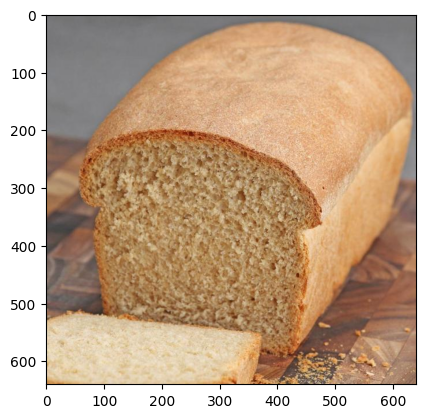

: 

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


import cv2
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
def show_image_nb(image_path, x1, y1, x2, y2):

    # Đọc hình 
    image = Image.open(image_path)

    # Lấy kích thước của hình ảnh
    height, width, channels = image.shape

    # Tọa độ góc trên bên trái và góc dưới bên phải của hình chữ nhật
    x1, y1 = 100, 100
    x2, y2 = 500, 400

    # Vẽ hình chữ nhật
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Hiển thị hình ảnh
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

def show_image_with_bbox(image_path, label_path):
    """
    Hiển thị hình ảnh và các bounding box từ file nhãn trên đó.

    Parameters:
    - image_path (str): Đường dẫn đến hình ảnh.
    - label_path (str): Đường dẫn đến file nhãn.

    Returns:
    - None.
    """
    # Đọc hình ảnh
    image = Image.open(image_path)
    
    # Tạo subplot và hiển thị hình ảnh
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Đọc tọa độ bounding box từ file nhãn
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Mỗi dòng trong file nhãn chứa các tọa độ bounding box
            # được phân tách bởi dấu khoảng trắng
            index_label, x_min, y_min, x_max, y_max = map(float, line.strip().split())

            show_image_nb(image_path, x_min, y_min, x_max, y_max)
            # # Tạo một Rectangle patch để biểu diễn bounding box
            # rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')

            # # Thêm Rectangle patch vào hình ảnh
            # ax.add_patch(rect)

    # Hiển thị hình ảnh với các bounding box
    # plt.show()



image_path = os.path.join(first_data['dataset_folder'], first_data['label'], IMAGE_FOLDER, first_data['filename'] + '.jpg')
label_path = os.path.join(first_data['dataset_folder'], first_data['label'], LABEL_FOLDER, first_data['filename'] + '.txt')
show_image_with_bbox(image_path, label_path)

# def read_bbox_from_label(label_file):
#     """
#     Đọc tọa độ bounding box từ file nhãn.
    
#     Parameters:
#     - label_file (str): Đường dẫn đến file nhãn.

#     Returns:
#     - list: Danh sách các bounding box, mỗi bounding box được biểu diễn bởi một tuple (x_min, y_min, x_max, y_max).
#     """
#     bboxes = []
#     with open(label_file, 'r') as f:
#         lines = f.readlines()
#         for line in lines:
#             # Mỗi dòng trong file nhãn thường chứa các tọa độ của bounding box
#             # được phân tách bởi dấu khoảng trắng
#             x_min, y_min, x_max, y_max = map(float, line.strip().split())
#             bboxes.append((x_min, y_min, x_max, y_max))
#     return bboxes

# def crop_image_with_bbox(image_path, label_path, n):
#     """
#     Cắt hình ảnh theo các tọa độ bounding box và cập nhật lại tọa độ bounding box.
    
#     Parameters:
#     - image_path (str): Đường dẫn đến hình ảnh.
#     - label_path (str): Đường dẫn đến file nhãn.
#     - n (int): Khoảng cách cắt hình ảnh.

#     Returns:
#     - None.
#     """
#     # Đọc các tọa độ bounding box từ file nhãn
#     bboxes = read_bbox_from_label(label_path)

#     # Đọc hình ảnh
#     image = Image.open(image_path)
#     width, height = image.size

#     for bbox in bboxes:
#         x_min, y_min, x_max, y_max = bbox

#         # Cắt hình ảnh và cập nhật lại tọa độ bounding box
#         x_min_new = max(0, int(x_min) - n)
#         y_min_new = max(0, int(y_min) - n)
#         x_max_new = min(width, int(x_max) + n)
#         y_max_new = min(height, int(y_max) + n)

#         # Cắt hình ảnh
#         cropped_image = image.crop((x_min_new, y_min_new, x_max_new, y_max_new))

#         # Lưu hình ảnh cắt
#         cropped_image.save(f"{image_path[:-4]}_cropped.jpg")

#         # Cập nhật lại tọa độ bounding box
#         bbox[0] = x_min_new
#         bbox[1] = y_min_new
#         bbox[2] = x_max_new
#         bbox[3] = y_max_new

#     # Ghi lại tọa độ bounding box mới vào file nhãn
#     with open(label_path, 'w') as f:
#         for bbox in bboxes:
#             f.write(' '.join(map(str, bbox)) + '\n')

# # n = 10
# # crop_image_with_bbox('path_to_image.jpg', 'path_to_label.txt', n)


# Copy all the images and labels to the dataset folder

In [ ]:
# remove the old raw folder
import shutil
import uuid


if os.path.exists(raw_folder):
    os.system(f'rm -rf {raw_folder}')

for item in final_items:
    image_path = item['image_path']
    label_path = item['label_path']

    new_name = uuid.uuid4().hex
    image_name = f'{new_name}.jpg'
    label_name = f'{new_name}.txt'

    new_image_path = os.path.join(raw_folder, 'images', image_name)
    new_label_path = os.path.join(raw_folder, 'labels', label_name)

    os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
    os.makedirs(os.path.dirname(new_label_path), exist_ok=True)

    shutil.copy(image_path, new_image_path)
    shutil.copy(label_path, new_label_path)

# Preprocessing the dataset
1. Auto-Orient: Applied
2. Resize: Stretch to 640x640
3. Static Crop: 24-80% Horizontal Region, 25-86% Vertical Region

# Augment the dataset
1. Flip: Horizontal
2. Crop: 0% Minimum Zoom, 30% Maximum Zoom
3. Grayscale: Apply to 10% of images
4. Hue: Between -10° and +10°
5. Saturation: Between -25% and +25%
6. Brightness: Between -25% and +25%
7. Exposure: Between -15% and +15%

<!-- 
Flip: Horizontal, Vertical
Crop: 0% Minimum Zoom, 30% Maximum Zoom
Hue: Between -25° and +25°
Saturation: Between -20% and +20%
Brightness: Between -20% and +20%
Exposure: Between -10% and +10% -->


<!-- Crop: 0% Minimum Zoom, 10% Maximum Zoom
Rotation: Between -10° and +10°
Grayscale: Apply to 10% of images
Hue: Between -15° and +15°
Saturation: Between -15% and +15%
Brightness: Between -15% and +15%
Exposure: Between -15% and +15%
Blur: Up to 0.75px
Cutout: 4 boxes with 3% size each
Mosaic: Applied -->


<!-- Rotation: Between -35° and +35°
Grayscale: Apply to 25% of images
Saturation: Between -65% and +65%
Exposure: Between -25% and +25% -->

<!-- Flip: Horizontal, Vertical
90° Rotate: Clockwise, Counter-Clockwise, Upside Down
Crop: 0% Minimum Zoom, 35% Maximum Zoom
Rotation: Between -15° and +15°
Grayscale: Apply to 5% of images
Hue: Between -25° and +25°
Saturation: Between -25% and +25%
Brightness: Between -20% and +20%
Exposure: Between -25% and +25%
Blur: Up to 0.5px
Cutout: 5 boxes with 3% size each -->

<!-- Flip: Horizontal
Crop: 0% Minimum Zoom, 20% Maximum Zoom
Rotation: Between -12° and +12°
Shear: ±3° Horizontal, ±3° Vertical
Grayscale: Apply to 10% of images
Hue: Between -20° and +20°
Saturation: Between -20% and +20%
Brightness: Between -15% and +15%
Exposure: Between -15% and +15%
Blur: Up to 1px
Cutout: 5 boxes with 3% size each -->

<!-- Outputs per training example: 3
Hue: Between -10° and +10°
Brightness: Between -10% and +10% -->

<!-- Flip: Horizontal
Rotation: Between -8° and +8°
Shear: ±2° Horizontal, ±2° Vertical
Grayscale: Apply to 10% of images
Hue: Between -15° and +15°
Saturation: Between -20% and +20%
Brightness: Between -20% and +20%
Exposure: Between -15% and +15%
Blur: Up to 1px
Cutout: 3 boxes with 3% size each -->